In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import chain, combinations

import scipy as stats
import statsmodels.api as sms
import scipy.stats as scipystats
import statsmodels.stats.stattools as stools
import copy, math, time 
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

# Graph library
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.regressionplots import *
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Checking linear regression assumptions
# Graph
from statsmodels.graphics.gofplots import ProbPlot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def resid_v_fitted(fitted_y, y, ax):
    '''Plots the residuals vs. fitted yvalues'''
    sns.residplot(fitted_y, y,
          lowess=True, scatter_kws={'alpha': 0.5},
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},ax=ax)
                 
    ax.set_title('Residuals vs Fitted')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

def normal_QQ_plot(norm_residuals, ax):
    QQ = ProbPlot(norm_residuals)
    QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax=ax)
    ax.set_title('Normal Q-Q')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Standardized Residuals')
    abs_norm_resid =norm_residuals.sort_values(ascending=False)
     
    
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3.index):
        ax.annotate(i, xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                        norm_residuals[i]));

def scale_loc_plot(fitted_y, norm_residuals, norm_residuals_abs_sqrt, ax):
    ax.scatter(fitted_y, norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(fitted_y, norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)
    ax.set_title('Scale-Location')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('$\sqrt{|Standardized Residuals|}$');

    # annotations
    abs_norm_resid = norm_residuals.sort_values(ascending=False)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    abs_sq_norm_resid = norm_residuals_abs_sqrt.sort_values(ascending=False)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
 
    for i in abs_norm_resid_top_3.index:
        ax.annotate(i, xy=(fitted_y[i],
                norm_residuals_abs_sqrt[i]))
        
def residuals_v_leverage_plot(norm_residuals, model_leverage, ax):
    ax.scatter(model_leverage, norm_residuals, alpha=0.5);
    sns.regplot(model_leverage, norm_residuals, scatter=False,
              ci=False, lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)
    
    ax.set_xlim(0, max(model_leverage)+0.01)
    ax.set_ylim(-3, 5)
    ax.set_title('Residuals vs Leverage')
    ax.set_xlabel('Leverage')
    ax.set_ylabel('Standardized Residuals')
    
        
def diagnostic_plots(model, X, y, return_high_leverage=False):
    fitted_y = model.fittedvalues
    residuals = model.resid
    norm_residuals = pd.Series(model.get_influence().resid_studentized_internal, index=fitted_y.index)
    norm_residuals_abs_sqrt = pd.Series(np.sqrt(np.abs(norm_residuals)), index=fitted_y.index)
    model_abs_resid = pd.Series(np.abs(residuals), index=fitted_y.index)
    model_leverage = pd.Series(model.get_influence().hat_matrix_diag, index=fitted_y.index)
    avg_leverage = model_leverage.mean()
    model_cooks = pd.Series(model.get_influence().cooks_distance[0], index=fitted_y.index)
    fig, ax = plt.subplots(2,2, figsize=(12,10))
    # Residuals vs. Fitted
    resid_v_fitted(fitted_y, y, ax=ax[0,0])
    # Normal QQ Plot
    normal_QQ_plot(norm_residuals, ax=ax[0,1])
    # Scale-Location
    scale_loc_plot(fitted_y, norm_residuals, norm_residuals_abs_sqrt, ax=ax[1,0])
    # Residuals vs. Leverage
    residuals_v_leverage_plot(norm_residuals, model_leverage,ax=ax[1,1])
    if return_high_leverage:
        return model_leverage[model_leverage > avg_leverage*2]
# diagnostic_plots(model, X, y, return_high_leverage=False)

In [3]:
# loading data
train_y = pd.read_csv("train.csv")["SalePrice"]
data = pd.read_csv("train1.csv").iloc[:,1:]
# data before dummification for multiconlinearity detection
train_x1 = data.iloc[:len(train_y)]
train_x1_cont = train_x1.select_dtypes(exclude = "object")

In [4]:
# dummification
data_dum = pd.get_dummies(data, drop_first = True)
# splitig data
train_X = data_dum.iloc[:len(train_y)]
data_dum.shape

(2919, 261)

## Linear Regression

In [5]:
# Applied Linear regression - baseline model
from sklearn.linear_model import LinearRegression 
org_ols = LinearRegression()
org_ols.fit(train_X,train_y)

coef = sorted(org_ols.coef_.tolist(), reverse = True)
intercept = org_ols.intercept_
RSS = np.sum((org_ols.predict(train_X) - train_y) ** 2)
R_square = org_ols.score(train_X, train_y) # 0.9330945017406497
R_square

0.933201211954752

In [6]:
from sklearn.metrics import mean_squared_error
y_true = train_y
y_pred = org_ols.predict(train_X)
mean_squared_error(y_true, y_pred, squared = False )

20525.248694204343

In [7]:
# Coef
colnames = train_X.columns
result = pd.DataFrame(org_ols.coef_).transpose()
result.columns = colnames.tolist()
result['intercept'] = org_ols.intercept_ 
result = result.transpose()
result.columns = ['coefficient']
result.sort_values('coefficient', ascending = False)[:5]

,coefficient
RoofMatl_Membran,667006.188281
RoofMatl_Metal,634775.741311
RoofMatl_WdShngl,626268.604829
RoofMatl_Tar&Grv,572798.030814
RoofMatl_CompShg,571421.196516


In [8]:
# Model Performace - statsmodel
X_add_const = sms.add_constant(train_X)
OLS = sms.OLS(train_y, X_add_const)
ans1 = OLS.fit()
print(ans1.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     67.24
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        03:06:28   Log-Likelihood:                -16569.
No. Observations:                1460   AIC:                         3.364e+04
Df Residuals:                    1208   BIC:                         3.497e+04
Df Model:                         251                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -5.865e+

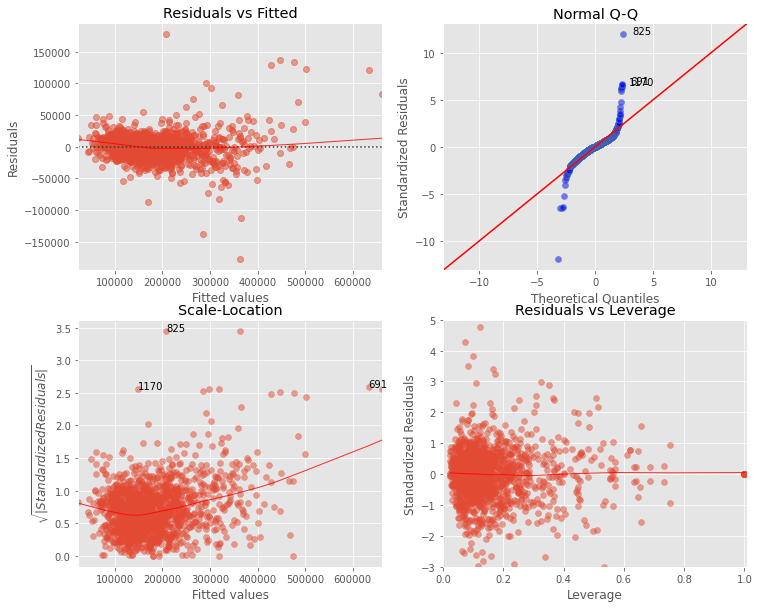

In [10]:
# checking assumptions
diagnostic_plots(ans1, train_X, train_y, return_high_leverage=False)
# heter, normality, influential points 

## Outliers detection and removal

In [11]:
# Outiler detection 
influence = ans1.get_influence()
pd.Series(influence.hat_matrix_diag).describe()
## get_influence() gets an instance of Influence with influence and outlier measures.

# show how to obtain studentized residuals, Cook’s Distances, DFFITS and leverage values. 
# The influence.summay_frame() provides these values automatically.
inf_sum = influence.summary_frame()
inf_sum.head(3)
student_resid = influence.resid_studentized_external # studentize residual
cooks, p1 = influence.cooks_distance # Cook's Distances
dffits, p2 = influence.dffits # DFFIT 
leverage = influence.hat_matrix_diag

Leverage vs. Studentized Residuals


Text(0, 0.5, 'Studentized Residuals')

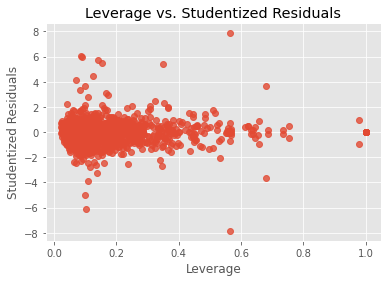

In [12]:
# Leverage vs residuals, a few high-residual point
print ('Leverage vs. Studentized Residuals')
sns.regplot(leverage, ans1.resid_pearson,  fit_reg=False)
plt.title('Leverage vs. Studentized Residuals')
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')
# signs of high leverage and high residual points

In [13]:
#Concat "Saleprice" and the resulting residual table
#Note that hat_diag is leverage, change the ciolumn heading from hat_diag to leverage
influence_sum = pd.concat([train_y, inf_sum], axis = 1)
influence_sum = influence_sum.rename(columns={'hat_diag': 'leverage'})
influence_sum.head()

,SalePrice,dfb_const,dfb_MSSubClass,dfb_LotFrontage,dfb_LotArea,dfb_OverallQual,dfb_OverallCond,dfb_YearBuilt,dfb_YearRemodAdd,dfb_MasVnrArea,...,dfb_SaleCondition_Alloca,dfb_SaleCondition_Family,dfb_SaleCondition_Normal,dfb_SaleCondition_Partial,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,208500,-0.000048,-0.000087,0.000089,-0.000014,-0.000065,0.000038,-0.000018,3.760848e-07,0.000003,...,0.000039,-0.000014,-0.000015,0.000022,5.580142e-09,-0.007663,0.024292,-0.001209,-0.007660,-0.001209
1,181500,0.015545,0.001170,-0.009364,0.025545,-0.016078,-0.069418,-0.010822,4.580954e-02,0.010333,...,-0.011648,-0.000024,-0.001912,0.028857,1.223512e-03,-1.175523,0.188297,-0.566180,-1.175709,-0.566270
2,223500,-0.006600,0.001851,-0.009421,0.021040,-0.007098,-0.005505,-0.004003,9.274350e-03,-0.012130,...,0.002561,0.010413,0.000977,0.000069,9.947859e-05,0.810471,0.038164,0.161442,0.810356,0.161419
3,140000,-0.006601,0.007372,0.028673,0.007669,-0.043515,0.078936,0.061514,2.712142e-02,-0.004275,...,0.044722,0.045409,0.128023,0.012893,1.297666e-03,-1.221388,0.185606,-0.583085,-1.221637,-0.583204
4,250000,0.010405,0.001477,0.023187,-0.024592,-0.039122,0.011499,0.000576,-1.660118e-02,0.026507,...,-0.015197,-0.013294,-0.015960,0.023028,1.097962e-03,-1.932028,0.071552,-0.536345,-1.934218,-0.536953


## Studentized Residuals and leverage
* studentized residuals for identifying outliers
* studentized residuals that exceed +2 or -2 are concerning
* studentized residuals that exceed +3 or -3 are extremely concerning
* If an observation has a studentized residual that is larger than 3 (in absolute value) we can call it an outlier
* large residual and large leverage = INFLUENTIAL

In [14]:
stud_resid = influence_sum.student_resid
stud_resid_index = [*influence_sum.SalePrice[abs(stud_resid) > 3].index]

In [15]:
# Identify high leverage
p = train_X.shape[1] + 1 # All parameters including intercept
n = train_X.shape[0] # n numbers of observations
thred = 3 # 2 or 3. 

cut_off = thred * (p / n) # Variations
leverages = influence_sum.leverage

high_leverages_index = [*influence_sum.SalePrice[abs(leverages) > cut_off].index]

In [16]:
outl = pd.DataFrame(influence_sum.SalePrice[abs(stud_resid) > 3]) 
lev = pd.DataFrame(influence_sum.SalePrice[abs(leverage) > cut_off])

Influential = pd.merge(outl,lev, left_index=True, right_index=True)
outlier = [*Influential.index]
outlier

[197, 523, 825, 1170, 1182, 1423]

## DFFITS, COOK, and One correlation test

In [17]:
# DFFITS
p = train_X.shape[1] # k includes all predictors 
n = train_X.shape[0] # n numbers of observations
cut_off_D = 2 * np.sqrt((p + 1) / (n - p - 1))
infl = pd.DataFrame(influence_sum.SalePrice[abs(influence_sum.dffits) > cut_off_D])
outlier1 = [*infl.index] 
print(outlier1)

[11, 30, 66, 70, 88, 93, 107, 120, 129, 153, 190, 197, 218, 237, 250, 253, 271, 298, 318, 326, 328, 335, 367, 377, 410, 412, 440, 457, 462, 469, 473, 479, 523, 529, 568, 574, 581, 582, 588, 595, 608, 629, 632, 662, 664, 666, 681, 688, 691, 693, 705, 716, 736, 740, 747, 762, 769, 774, 803, 809, 810, 825, 873, 885, 898, 913, 948, 955, 970, 1000, 1003, 1044, 1046, 1138, 1169, 1170, 1173, 1180, 1181, 1182, 1187, 1211, 1267, 1275, 1292, 1312, 1321, 1324, 1359, 1386, 1387, 1423]


In [18]:
p = train_X.shape[1] # p includes all predictors 
n = train_X.shape[0] # n numbers of observations
cutoff = 4 / n
cook_d = pd.DataFrame((influence_sum.SalePrice[abs(influence_sum.cooks_d) > cutoff]))
outlier2 = [*cook_d.index] 
print(outlier2)

[11, 30, 66, 70, 88, 93, 107, 120, 129, 153, 175, 190, 197, 218, 237, 249, 250, 253, 261, 271, 298, 318, 326, 328, 335, 367, 377, 380, 410, 412, 440, 457, 462, 469, 473, 479, 496, 523, 529, 568, 574, 581, 582, 588, 595, 608, 629, 632, 662, 664, 666, 676, 681, 688, 691, 693, 705, 716, 736, 740, 747, 762, 769, 774, 803, 809, 810, 812, 825, 828, 873, 885, 898, 913, 948, 954, 955, 970, 1000, 1003, 1044, 1046, 1131, 1138, 1139, 1169, 1170, 1173, 1180, 1181, 1182, 1187, 1200, 1211, 1264, 1267, 1275, 1292, 1312, 1321, 1324, 1359, 1386, 1387, 1423, 1440]


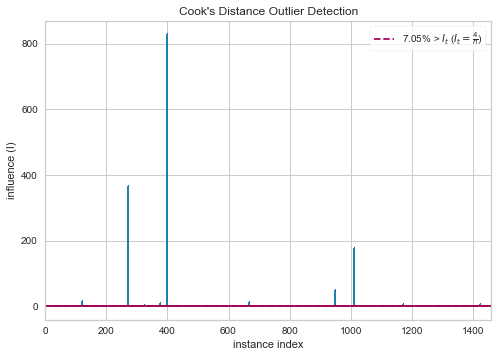

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [19]:
from yellowbrick.regressor import CooksDistance
# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(train_X,train_y)
visualizer.show()

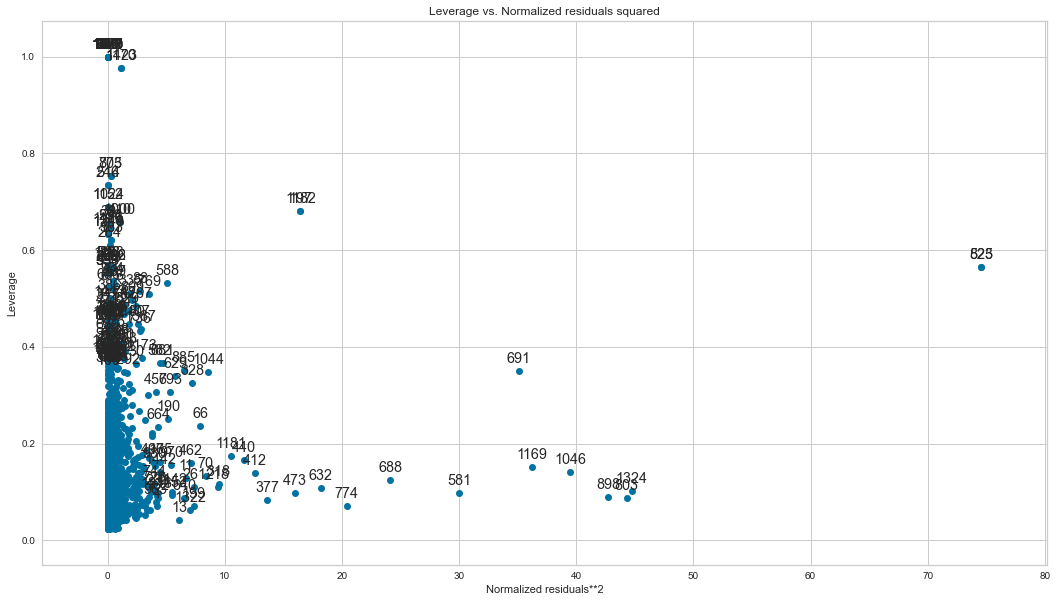

In [20]:
fig, ax = plt.subplots(figsize=(18,10))
plot_leverage_resid2(ans1, alpha=0.05, ax = ax)
plt.show()

In [21]:
# Remove additional outliers
ols = sms.OLS(endog = train_y,
             exog = train_X)
fit = ols.fit()
test2 = fit.outlier_test()['bonf(p)']

outlier3 = list(test2[test2<1e-2].index)

print('There were {:.0f} outliers at indices:'.format(len(outlier3)))
print(outlier3)

"""
The Bonferroni Outlier Tests uses a t-distribution to test whether the model’s largest studentized residual value’s outlier status is statistically different from the other observations in the model.
A significant p-value indicates an extreme outlier that warrants further examination.
"""

There were 14 outliers at indices:
[197, 523, 581, 688, 691, 803, 825, 898, 1046, 1169, 1170, 1182, 1324, 1423]


'\nThe Bonferroni Outlier Tests uses a t-distribution to test whether the model’s largest studentized residual value’s outlier status is statistically different from the other observations in the model.\nA significant p-value indicates an extreme outlier that warrants further examination.\n'

In [22]:
# Remove outliers
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
train_x1 = train_X.copy()
train_y1 = train_y.copy()
indices = [outlier ,outlier1, outlier2, outlier3]
for i in range(len(indices)):
    X = train_x1.copy().drop(indices[i], axis = 0)
    Y = train_y1.copy().drop(indices[i], axis = 0)
    model= sms.OLS(np.log(Y), sms.add_constant(X)).fit()
    ols = LinearRegression().fit(X, np.log(Y))
    MSE = mean_squared_error(np.log(Y), ols.predict(X), squared = False)
    print(MSE, model.aic, model.bic)
    print(len(indices[i]))
# Outlier1 which is Cook Distance reduce MSE the most, also AIC and BIC

0.09064074585904948 -2359.4027140280696 -1049.4484468208902
6
0.07650226296227902 -2690.494216546158 -1489.640043964184
92
0.07518321744258777 -2705.3506321889636 -1506.862387890353
106
0.0880588621702914 -2427.266183026184 -1118.680195151944
14


In [23]:
# Remove outliers
train_X = train_X.drop(outlier2)
train_y = train_y.drop(outlier2)

## Feature Selection - regression analysis

In [24]:
from sklearn.feature_selection import RFECV, SelectKBest,f_regression, mutual_info_regression, VarianceThreshold
from sklearn.model_selection import GridSearchCV, cross_val_score,  KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
kfolds = KFold(n_splits = 10 , shuffle = True, random_state = 42)

In [26]:
# PCA 
train_X_pca = StandardScaler().fit_transform(train_X)

In [27]:
# Gridsearching PCA n_components
from sklearn.decomposition import PCA
pca = PCA()
pipeline = Pipeline(steps=[('pca', pca),
                   ('model', LinearRegression())])
param_grid = {
    'pca__n_components': range(100, 261)
}
search = GridSearchCV(pipeline, 
                      param_grid, 
                      n_jobs = -1,
                      cv = kfolds,
                      verbose = 3,
                      scoring = "neg_mean_squared_error"
                     )
search = search.fit(train_X_pca, np.log(train_y))
print(search.best_params_, search.best_score_)
# 10 - 203, 202, 191

Fitting 10 folds for each of 161 candidates, totalling 1610 fits
{'pca__n_components': 197} -0.016304111464681366


In [28]:
best_components = search.best_params_['pca__n_components']
pca.set_params(n_components = best_components)
trainx = pca.fit_transform(train_X_pca)
############

from sklearn.metrics import mean_squared_error
ols = LinearRegression()
ols.fit(trainx, np.log(train_y))
y_true = np.log(train_y)
y_pred = ols.predict(trainx)
RMSE = mean_squared_error(y_true, y_pred, squared = False)
MSE = mean_squared_error(y_true, y_pred, squared = True)
R2 = ols.score(trainx, np.log(train_y))
print(RMSE, R2, MSE)

0.08139405456622044 0.9531716772961246 0.00662499211872887


In [30]:
rfe_mod = RFECV(ols, step=1, cv = kfolds, n_jobs = -1) #RFE(lin_reg, 4, step=1)
myvalues=rfe_mod.fit(train_X, np.log(train_y)) #to fit
# 10cv - 248, 5 cv = 228, 3cv = 222
rankings = pd.DataFrame(myvalues.ranking_)
names = pd.DataFrame(train_X.columns)
#Concat and name columns
ranked = pd.concat([names,rankings], axis = 1)
ranked.columns = ["Feature", "Rank"]
ranked = ranked.set_index("Feature")
#Select most important (Only 1's)
most_important = ranked[ranked['Rank'] ==1].index
myvalues.n_features_

244

In [31]:
pipeline = Pipeline([('selector',SelectKBest(f_regression)),
                     ('model',LinearRegression())])
pipeline.get_params().keys()
search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'selector__k': range(1, 261, 1),
                  },
    n_jobs=-1,
    scoring="neg_mean_squared_error",
    cv = kfolds,
    verbose=3)
search = search.fit(train_X, np.log(train_y))
k = search.best_params_['selector__k']
new_x = SelectKBest(f_regression, k = k).fit(train_X, np.log(train_y))
new_x = pd.DataFrame(new_x.get_support(indices = False), index = train_X.columns, columns = { 0: "Select"})
# vif["features"] = train_X.columns
f_regression = new_x[new_x[0] == True].index

Fitting 10 folds for each of 260 candidates, totalling 2600 fits


In [32]:
pipeline = Pipeline([('selector',SelectKBest(mutual_info_regression)),
                     ('model',LinearRegression())])
pipeline.get_params().keys()
search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'selector__k': range(1, 261, 5),
                  },
    n_jobs=-1,
    scoring="neg_mean_squared_error",
    cv = kfolds,
    verbose=3)
search = search.fit(train_X, np.log(train_y))
print(search.best_params_, search.best_score_)
k = search.best_params_['selector__k']
new_x = SelectKBest(mutual_info_regression, k = k).fit(train_X, np.log(train_y))
new_x = pd.DataFrame(new_x.get_support(indices = False), index = train_X.columns, columns = { 0: "Select"})
mutual_info = new_x[new_x[0] == True].index

Fitting 10 folds for each of 52 candidates, totalling 520 fits
{'selector__k': 216} -0.015814707944178785


In [35]:
train_x1 = train_X.copy()
train_y1 = train_y.copy()
list_index = [mutual_info, f_regression, most_important]
for i in range(len(list_index)):
    x = train_x1[list_index[i]]
    y = np.log(train_y1)
    ols = LinearRegression(n_jobs = -1).fit(x,y)
    Score = ols.score(x, y)
    MSE = mean_squared_error(y, ols.predict(x))
    RMSE = mean_squared_error(y, ols.predict(x), squared=False)
    print(MSE ,RMSE, Score, x.shape[1]) 
# RFECV is better

0.0060894312582695995 0.07803480799149569 0.9569572541468883 216
0.006120494908677146 0.07823359194538589 0.9567376827693568 202
0.005833861906015141 0.07637972182467766 0.9587637293677054 244


In [39]:
# Using RFE for feature selection
train_X = train_X[most_important]

In [40]:
# processing for y
train_y = np.log(train_y).reset_index()
train_y = train_y["SalePrice"]

In [41]:
mean = train_y.mean()
med = train_y.median()
std = train_y.std()
skew = train_y.skew()
kurt = train_y.kurt()
print('SalePrice\n mean = {:.2f}\n median = {:.2f} \n standard deviation = {:.2f} \n skew = {:.2f} \n kurtosis = {:.2f}'.format(mean, med, std, skew, kurt))

SalePrice
 mean = 2.49
 median = 2.48 
 standard deviation = 0.03 
 skew = -0.12 
 kurtosis = 0.76


In [42]:
# Apply power transofrmation on X 
train_X1 = train_X.copy()
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True,) 
#Fit the data to the powertransformer
skl_yeojohnson = pt.fit(train_X1)

calc_lambdas = skl_yeojohnson.lambdas_

#Transform the data 
skl_yeojohnson = pt.transform(train_X1)

#Pass the transformed data into a new dataframe 
train_X1 = pd.DataFrame(data = skl_yeojohnson, columns = train_X.columns)

In [43]:
# Model Performace - statsmodel
X_add_const = sms.add_constant(train_X1)
OLS = sms.OLS(train_y, X_add_const)
ans2 = OLS.fit()
print(ans2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     114.2
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        03:20:59   Log-Likelihood:                 4922.5
No. Observations:                1354   AIC:                            -9387.
Df Residuals:                    1125   BIC:                            -8194.
Df Model:                         228                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.48

In [44]:
from sklearn.metrics import mean_squared_error
ols = LinearRegression()
ols.fit(train_X1, train_y)
y_true = train_y
y_pred = ols.predict(train_X1)
RMSE = mean_squared_error(y_true, y_pred, squared = False)
R2 = ols.score(train_X1, train_y)
print(RMSE, R2)

0.006379969745168835 0.958600412513471


## Penalization regression - Lasso, Ridge, ElasticNet

In [45]:
# for penalization models
trainX, trainy = train_X.copy(), np.log(train_y).copy()

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [48]:
rkfolds = KFold(n_splits = 10 , shuffle = True, random_state = 42)
ridgecv = RidgeCV(cv = rkfolds, 
                  normalize = True,
                  scoring = "neg_mean_squared_error",).fit(trainX, trainy)

In [49]:
alphar = ridgecv.alpha_
alphas = ridgecv.best_score_
print(alphar)
print(ridgecv.score(trainX, trainy))

0.1
0.9476319871712082


In [50]:
y_true = trainy
y_pred = ridgecv.predict(trainX)
RMSE = mean_squared_error(y_true, y_pred, squared=False)
RMSE

0.002889913368795028

In [52]:
lkfolds = KFold(n_splits = 10, shuffle = True, random_state = 42)

In [53]:
lassocv = LassoCV(cv = lkfolds, n_jobs = -1, normalize = True,).fit(trainX, trainy)
best_lasso = lassocv.alpha_
best_lasso

2.1097647714268986e-06

In [54]:
y_true = trainy
y_pred = lassocv.predict(trainX)
RMSE = mean_squared_error(y_true, y_pred, squared=False)
score = lassocv.score(trainX, trainy)
print(RMSE, score)

0.0030190154430795257 0.9428485681717628


In [55]:
lassoCoef = pd.Series(lassocv.coef_, index = trainX.columns)
sortedCoefs = np.abs(lassoCoef).sort_values(ascending=False)
lasso_feature = sortedCoefs[sortedCoefs == 0].index
sortedCoefs[sortedCoefs != 0].head(15)

PoolQC_Gd                0.040544
Functional_Maj2          0.007026
RoofMatl_WdShngl         0.006477
Heating_Grav             0.005666
SaleType_Oth             0.003810
Neighborhood_Crawfor     0.003567
Neighborhood_MeadowV     0.003424
SaleType_CWD             0.003143
SaleCondition_Partial    0.002641
Exterior1st_BrkFace      0.002500
GarageCond_Po            0.002478
Condition2_PosA          0.002383
CentralAir_Y             0.002319
Heating_GasW             0.002293
SaleCondition_Normal     0.002241
dtype: float64

In [56]:
nkfolds = KFold(n_splits = 10, shuffle = True, random_state = 23)
netcv = ElasticNetCV(normalize = True, cv = nkfolds, n_jobs = -1, l1_ratio = [.15,.25, .4, .5, .7, .9, .95, .99, 1]).fit(trainX, trainy)
print(netcv.alpha_, netcv.l1_ratio_)
y_true = trainy
y_pred = netcv.predict(trainX)
RMSE = mean_squared_error(y_true, y_pred, squared=False)
score = netcv.score(trainX, trainy)
print(RMSE, score)

1.5081544070354431e-05 0.15
0.0030454486394420875 0.9418434003974658


In [57]:
netCoef = pd.Series(netcv.coef_, index = trainX.columns)
sortedCoefs = np.abs(netCoef).sort_values(ascending=False)
net_feature = sortedCoefs[sortedCoefs == 0].index

In [58]:
# rerun linear regression
from sklearn.metrics import mean_squared_error
li = [lasso_feature, net_feature]
for i in range(len(li)):
    y = np.log(train_y.copy())
    x = train_X1.copy()
    x = x.drop(li[i], axis = 1)
    ols= LinearRegression()
    ols.fit(x, y)
    r2 = ols.score(x, y)
    y_true = y
    y_pred = ols.predict(x)
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
#     linear_regression_assumptions(x, y, feature_names=x.columns)
    print(r2, RMSE)

0.9475540399940312 0.0028920633150814603
0.9488937598576112 0.002854885813780558


In [62]:
# Support Vector Regression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
kfolds = KFold(n_splits = 5 , shuffle = True, random_state = 42)

pipeline = Pipeline([('model', SVR())])
pipeline.get_params().keys()
search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'model__C': np.linspace(1e-2,1e-1, 50),
                  'model__epsilon' : np.linspace(1e-6 ,1e-5, 50),
                  'model__gamma': ["auto"]
                  },
    n_jobs=-1,
    scoring="neg_mean_squared_error",
    cv = kfolds,
    verbose= 3)
search = search.fit(train_X1, train_y)
print(search.best_params_, search.best_score_)

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
{'model__C': 0.09448979591836734, 'model__epsilon': 4.857142857142857e-06, 'model__gamma': 'auto'} -0.00017858945102885003


In [63]:
best_parms = search.best_params_
svr = SVR(C = 0.1, epsilon = 3.7551020408163268e-06,gamma = "auto").fit(train_X1,train_y)
score = svr.score(train_X1, train_y)
y_true = train_y
y_pred = svr.predict(train_X1)
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(score, RMSE)

0.9969015578932652 0.0017453892843183891


In [ ]:
# Ramdon Forest
from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([("RF", RandomForestRegressor(bootstrap = True))])
# pipeline.get_params().keys()
search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'RF__n_estimators': range(1, 101, 10 ), # number of tress
                  'RF__max_features': range(10, 50, 10), # number of features to resample
                  'RF__max_depth': range(10, 50, 10), # depth of the tree
                  'RF__min_samples_leaf': range(10, 50, 10),
                  'RF__min_samples_split': range(10, 50, 10),
                  'RF__oob_score': [True]},
    n_jobs=-1,
    scoring = "neg_mean_squared_error",
    cv = tfolds,
    verbose=3)
search = search.fit(train_X, train_y)
print(search.best_params_, search.best_score_)

In [64]:
rf = RandomForestRegressor(bootstrap = True, 
                           n_estimators = 81,
                           max_features = 40,
                           max_depth = 30,
                           min_samples_leaf = 10, 
                           min_samples_split = 10,
                           oob_score = True,
                          )
rf.fit(train_X, train_y)
score = rf.score(train_X, train_y)
y_pred = rf.predict(train_X)
y_true = train_y
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(score, RMSE)

0.9071001578241816 0.009557143356643882


In [68]:
rf_features = pd.DataFrame(rf.feature_importances_,
                           index = train_X.columns).rename(columns = {0: "Features"})
re_features_index = rf_features[rf_features.Features > 0].index
train_X_rf = train_X[re_features_index]
rf_features.sort_values(by = "Features", ascending = False)

,Features
Totalsf,0.158342
OverallQual,0.144135
GrLivArea,0.120992
YearBuilt,0.078984
GarageCars,0.054992
...,...
Condition1_RRAe,0.000000
Condition1_RRAn,0.000000
Exterior2nd_Wd Shng,0.000000
Condition1_RRNn,0.000000


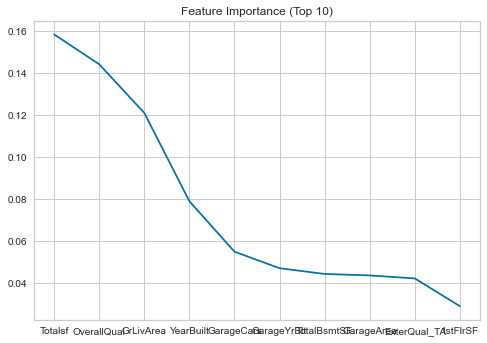

In [69]:
plt.plot(rf_features[rf_features.Features > 0].sort_values(by = "Features", ascending = False).head(10))
plt.title("Feature Importance (Top 10)")
plt.savefig("fI.png")
plt.show()

In [71]:
# Drop features
pipeline = Pipeline([("RF", RandomForestRegressor(bootstrap = True))])
# pipeline.get_params().keys()
search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'RF__n_estimators': range(1, 101, 10 ), # number of tress
                  'RF__max_features': range(10, 50, 10), # number of features to resample
                  'RF__max_depth': range(10, 50, 10), # depth of the tree
                  'RF__min_samples_leaf': range(10, 50, 10),
                  'RF__min_samples_split': range(10, 50, 10),
                  'RF__oob_score': [True]},
    n_jobs=-1,
    scoring = "neg_mean_squared_error",
    cv = tfolds,
    verbose=3)
search = search.fit(train_X_rf, train_y)
print(search.best_params_, search.best_score_)

In [72]:
rf = RandomForestRegressor(bootstrap = True, 
                           n_estimators = 81,
                           max_features = 40,
                           max_depth = 30,
                           min_samples_leaf = 10, 
                           min_samples_split = 20,
                           oob_score = True,
                          )
rf.fit(train_X_rf, train_y)
score = rf.score(train_X_rf, train_y)
y_pred = rf.predict(train_X_rf)
y_true = train_y
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(score, RMSE)

0.9191437940630824 0.008916148472298525


In [ ]:
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingRegressor
gfolds = KFold(n_splits=5, shuffle = True, random_state= 42)
pipeline = Pipeline([("GBR", GradientBoostingRegressor())])
pipeline.get_params().keys()
search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'GBR__learning_rate': np.linspace(1e-1,1, 20), 
                  'GBR__max_depth': range(10, 50, 10), 
                  'GBR__max_features': ['auto', 'sqrt', 'log2'], 
                  'GBR__min_samples_split': range(10, 60, 10),
                  'GBR__n_estimators': range(10, 60, 10),
                  'GBR__subsample': np.linspace(1e-1,1,5)},
    n_jobs = -1,
    scoring = "neg_mean_squared_error",
    cv = gfolds,
    verbose=3)
search = search.fit(train_X, train_y)
print(search.best_params_, search.best_score_)

In [ ]:
gbr = GradientBoostingRegressor(learning_rate = 0.1, 
                                max_depth=20, 
                                max_features= "auto", 
                                min_samples_split=50, 
                                n_estimators= 50, 
                                subsample=0.325)
gbr.fit(train_X, train_y)
score = gbr.score(train_X, train_y)
y_pred = gbr.predict(train_X)
y_true = train_y
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(score, RMSE)

In [ ]:
gbr_features = pd.DataFrame(gbr.feature_importances_,
                           index = train_X.columns).rename(columns = {0: "Features"})
gbr_features_index = gbr_features[rf_features.Features > 0].index
train_X_gbr = train_X[re_features_index]

In [ ]:
gbr = GradientBoostingRegressor(learning_rate = 0.1, 
                                max_depth=20, 
                                max_features= "auto", 
                                min_samples_split=40, 
                                n_estimators= 40, 
                                subsample=0.325)
gbr.fit(train_X_gbr, train_y)
score = gbr.score(train_X_gbr, train_y)
y_pred = gbr.predict(train_X_gbr)
y_true = train_y
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(score, RMSE)

In [ ]:
# Xgboost
xfolds = KFold(n_splits= 3, shuffle = True, random_state= 42)
pipeline = Pipeline([("xgb", XGBRegressor(n_jobs = -1, objective='reg:squarederror'))])
pipeline.get_params().keys()
search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'xgb__gamma': np.linspace(1e-5,1, 5), 
                  'xgb__learning_rate': np.linspace(1e-1, 1, 5), 
                  'xgb__max_depth': range(5, 25, 5), 
                  'xgb__min_child_weight': range(1, 20, 10),
                  'xgb__n_estimators': [50, 100, 150, 200],
                  'xgb__subsample': np.linspace(1e-5,1, 5),
                  'xgb__reg_alpha': np.linspace(1e-1,1, 5),
                  'xgb__colsample_bytree':np.linspace(1e-5,1, 5),
                 },
    n_jobs = -1,
    scoring = "neg_mean_squared_error",
    cv = xfolds,
    verbose=3)
search = search.fit(train_X, train_y)
print(search.best_params_, search.best_score_)

In [ ]:
xgb = XGBRegressor(n_jobs = -1, 
                   objective='reg:squarederror',
                   colsample_bytree = 0.2500075, 
                   gamma = 1e-5,
                   learning_rate = 0.1, 
                   max_depth = 5, min_child_weight = 11, 
                   n_estimators = 200, 
                   reg_alpha = 0.325, 
                   subsample = 0.7500025).fit(train_X, train_y)
score = xgb.score(train_X, train_y)
y_pred = xgb.predict(train_X)
y_true = train_y
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(score, RMSE)